In [ ]:
import pandas as pd
import numpy as np

In [5]:
# import dataset into a pandas data frame

df = pd.read_csv('../41467_2022_32829_MOESM5_ESM.csv')
df.head()

,ID,DNA1 [counts],DNA2 [counts],DNA3 [counts],RNA1 [counts],RNA2 [counts],RNA3 [counts],TX1 [au],TX2 [au],TX3 [au],...,high quality,Observed log(TX/Txref),Predicted log(TX/Txref),dG10,dG35,dGDisc,dGITR,dGEXT10,dGSPAC,dGUP
0,0,8263,7261,5173,16341,10320,13506,2.258071,1.523795,1.545541,...,Yes,-3.386326,-3.844827,-1.781524,-1.477218,-0.106428,-0.021112,0.191352,-0.0924,0.400862
1,1,5600,4886,3264,10986,7250,10800,2.240001,1.590845,1.958709,...,Yes,-3.503140,-3.905283,-1.781524,-1.477218,-0.166884,-0.021112,0.191352,-0.0924,0.400862
2,2,7898,6790,4752,19572,32204,30585,2.829533,5.084911,3.810029,...,Yes,-4.207206,-3.905283,-1.781524,-1.477218,-0.166884,-0.021112,0.191352,-0.0924,0.400862
3,3,10651,9875,6466,15734,16246,18908,1.686729,1.763814,1.731036,...,Yes,-3.392439,-3.877808,-1.781524,-1.477218,-0.139409,-0.021112,0.191352,-0.0924,0.400862
4,4,12188,10793,6965,28609,21796,26803,2.680198,2.165100,2.278025,...,Yes,-3.698903,-3.672384,-1.781524,-1.477218,0.066015,-0.021112,0.191352,-0.0924,0.400862


In [6]:
# All input and output data

X = df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']]
y = df['Observed log(TX/Txref)']

X.head()

,UP,h35,spacs,h10,disc,ITR
0,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CCCCGCGG,CTCTACCTTAGTTTGTACGTT
1,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGCGGCGG,CTCTACCTTAGTTTGTACGTT
2,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGCGCCCG,CTCTACCTTAGTTTGTACGTT
3,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,GCGGCGGC,CTCTACCTTAGTTTGTACGTT
4,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGGGGGGC,CTCTACCTTAGTTTGTACGTT


In [7]:
# remove all rows with spacer sequences that are not 16-18 nucleotides long


_df = df[(df['spacs'].str.len() >= 15) & (df['spacs'].str.len() <= 19)]


X = _df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']]
y = _df['Observed log(TX/Txref)']

print(f'Removed {df.shape[0] - _df.shape[0]} rows')


Removed 140 rows


In [8]:
# Function to one-hot encode DNA sequences, including padding 0's

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = []
    for nucleotide in sequence:
         encoding += [mapping[nucleotide]]
    return encoding

In [9]:
upstream_padding = {}

for col in X.columns:
    max_len = X[col].apply(len).max()
    upstream_padding[col] = np.array([padded_one_hot_encode('0' * (max_len - len(seq)) + seq) for seq in X[col]])

# Concatenate the one-hot encoded, upstream-padded sequences
X = np.concatenate([upstream_padding[col] for col in X.columns], axis=1)

In [10]:
# split the data in training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

In [11]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout

In [12]:
def initModel(hidden_layers, neurons, epochs=150, batch_size=32):
    # Define RNN model architecture
    regressor = Sequential()
    regressor.add(Input(shape=X.shape[1:])) # dynamically generated input shape based on X data
    for i in range(hidden_layers-1):
        regressor.add(LSTM(neurons, return_sequences=True))
    regressor.add(LSTM(neurons))
    regressor.add(Dense(1, activation='linear'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    regressor.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = regressor.fit(X_train,
                            y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping])

    # Evaluate the model
    return regressor, regressor.evaluate(X_test, y_test)

In [13]:
results = []

In [14]:
hidden_layers = 1
neurons = [16, 32, 64, 96, 128]
epochs = 150
batch_size = 32

for n in neurons:
    print(f"Hidden Layers: {hidden_layers}, Neurons {n}"), 
    regressor, mse = initModel(hidden_layers, n, epochs, batch_size)
    results.append({'MSE': mse, 'Hidden Layers': hidden_layers, 'Neurons': n, 'Model': regressor})
    

Hidden Layers: 1, Neurons 16
Epoch 1/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.7647 - val_loss: 0.5081
Epoch 2/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4672 - val_loss: 0.3525
Epoch 3/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3468 - val_loss: 0.3264
Epoch 4/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3219 - val_loss: 0.3210
Epoch 5/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2931 - val_loss: 0.2794
Epoch 6/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2828 - val_loss: 0.2693
Epoch 7/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.2656 - val_loss: 0.2713
Epoch 8/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2632 - val_loss: 0.2557
Epoch 9/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2485 - val_loss: 0.2547
Epoch 10/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2475 - val_loss: 0.2658
Epoch 11/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2575 - val_loss: 0.2500
Epoch 12

In [15]:
df_results = pd.DataFrame(results)

df_results.sort_values(by='MSE').head(None)

,MSE,Hidden Layers,Neurons,Model
3,0.141757,1,96,"<Sequential name=sequential_3, built=True>"
4,0.144534,1,128,"<Sequential name=sequential_4, built=True>"
2,0.145036,1,64,"<Sequential name=sequential_2, built=True>"
1,0.147063,1,32,"<Sequential name=sequential_1, built=True>"
0,0.168463,1,16,"<Sequential name=sequential, built=True>"


In [16]:
hidden_layers = 2
neurons = [16, 32, 64, 96, 128]
epochs = 150
batch_size = 32

for n in neurons:
    print(f"Hidden Layers: {hidden_layers}, Neurons {n}"), 
    regressor, mse = initModel(hidden_layers, n, epochs, batch_size)
    results.append({'MSE': mse, 'Hidden Layers': hidden_layers, 'Neurons': n, 'Model': regressor})
    

Hidden Layers: 2, Neurons 16
Epoch 1/150


334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 2.1447 - val_loss: 0.5425
Epoch 2/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5518 - val_loss: 0.5234
Epoch 3/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.4095 - val_loss: 0.2965
Epoch 4/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2916 - val_loss: 0.2770
Epoch 5/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2786 - val_loss: 0.2720
Epoch 6/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2774 - val_loss: 0.2787
Epoch 7/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2607 - val_loss: 0.2862
Epoch 8/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2563 - val_loss: 0.2462
Epoch 9/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2427 - val_loss: 0.2291
Epoch 10/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2464 - val_loss: 0.2317
Epoch 11/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2350 - val_loss: 0.2299
Epoch 12/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
df_results = pd.DataFrame(results)

df_results.sort_values(by='MSE').head(None)

,MSE,Hidden Layers,Neurons,Model
3,0.141757,1,96,"<Sequential name=sequential_3, built=True>"
8,0.141924,2,96,"<Sequential name=sequential_8, built=True>"
4,0.144534,1,128,"<Sequential name=sequential_4, built=True>"
9,0.144724,2,128,"<Sequential name=sequential_9, built=True>"
2,0.145036,1,64,"<Sequential name=sequential_2, built=True>"
1,0.147063,1,32,"<Sequential name=sequential_1, built=True>"
7,0.148014,2,64,"<Sequential name=sequential_7, built=True>"
6,0.153365,2,32,"<Sequential name=sequential_6, built=True>"
0,0.168463,1,16,"<Sequential name=sequential, built=True>"
5,0.182994,2,16,"<Sequential name=sequential_5, built=True>"


In [18]:
hidden_layers = 3
neurons = [16, 32, 64, 96, 128]
epochs = 150
batch_size = 32

for n in neurons:
    print(f"Hidden Layers: {hidden_layers}, Neurons {n}"), 
    regressor, mse = initModel(hidden_layers, n, epochs, batch_size)
    results.append({'MSE': mse, 'Hidden Layers': hidden_layers, 'Neurons': n, 'Model': regressor})
    

Hidden Layers: 3, Neurons 16
Epoch 1/150


334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 1.6962 - val_loss: 0.5273
Epoch 2/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.4375 - val_loss: 0.3173
Epoch 3/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2956 - val_loss: 0.2798
Epoch 4/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2861 - val_loss: 0.2625
Epoch 5/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2645 - val_loss: 0.2508
Epoch 6/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2491 - val_loss: 0.2662
Epoch 7/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2466 - val_loss: 0.2456
Epoch 8/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2316 - val_loss: 0.2894
Epoch 9/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2454 - val_loss: 0.2523
Epoch 10/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2382 - val_loss: 0.2475
Epoch 11/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2405 - val_loss: 0.2545
Epoch 12/150
334/334 ━━━━━━━━━━━━━━━━━━━━

In [19]:
df_results = pd.DataFrame(results)

df_results.sort_values(by='MSE').head(None)

,MSE,Hidden Layers,Neurons,Model
3,0.141757,1,96,"<Sequential name=sequential_3, built=True>"
8,0.141924,2,96,"<Sequential name=sequential_8, built=True>"
12,0.142399,3,64,"<Sequential name=sequential_12, built=True>"
14,0.143165,3,128,"<Sequential name=sequential_14, built=True>"
4,0.144534,1,128,"<Sequential name=sequential_4, built=True>"
9,0.144724,2,128,"<Sequential name=sequential_9, built=True>"
2,0.145036,1,64,"<Sequential name=sequential_2, built=True>"
13,0.145470,3,96,"<Sequential name=sequential_13, built=True>"
1,0.147063,1,32,"<Sequential name=sequential_1, built=True>"
7,0.148014,2,64,"<Sequential name=sequential_7, built=True>"


In [20]:
hidden_layers = 4
neurons = [16, 32, 64, 96, 128]
epochs = 150
batch_size = 32

for n in neurons:
    print(f"Hidden Layers: {hidden_layers}, Neurons {n}"), 
    regressor, mse = initModel(hidden_layers, n, epochs, batch_size)
    results.append({'MSE': mse, 'Hidden Layers': hidden_layers, 'Neurons': n, 'Model': regressor})
    

Hidden Layers: 4, Neurons 16
Epoch 1/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 1.4795 - val_loss: 0.5478
Epoch 2/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.5322 - val_loss: 0.3206
Epoch 3/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.3019 - val_loss: 0.2833
Epoch 4/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.2759 - val_loss: 0.2555
Epoch 5/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.2623 - val_loss: 0.2463
Epoch 6/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.2498 - val_loss: 0.2520
Epoch 7/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.2379 - val_loss: 0.2406
Epoch 8/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.2367 - val_loss: 0.2384
Epoch 9/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.2367 - val_loss: 0.2346
Epoch 10/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.2325 - val_loss: 0.2360
Epoch 11/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.2335 - val_los

In [21]:
df_results = pd.DataFrame(results)

df_results.sort_values(by='MSE').head(None)

,MSE,Hidden Layers,Neurons,Model
3,0.141757,1,96,"<Sequential name=sequential_3, built=True>"
8,0.141924,2,96,"<Sequential name=sequential_8, built=True>"
12,0.142399,3,64,"<Sequential name=sequential_12, built=True>"
14,0.143165,3,128,"<Sequential name=sequential_14, built=True>"
4,0.144534,1,128,"<Sequential name=sequential_4, built=True>"
17,0.144564,4,64,"<Sequential name=sequential_17, built=True>"
9,0.144724,2,128,"<Sequential name=sequential_9, built=True>"
2,0.145036,1,64,"<Sequential name=sequential_2, built=True>"
18,0.145313,4,96,"<Sequential name=sequential_18, built=True>"
19,0.145463,4,128,"<Sequential name=sequential_19, built=True>"


In [79]:
hidden_layers = [1, 2, 3, 4]
neurons = 160
epochs = 150
batch_size = 32

for h in hidden_layers:
    print(f"Hidden Layers: {h}, Neurons {n}"), 
    regressor, mse = initModel(h, n, epochs, batch_size)
    results.append({'MSE': mse, 'Hidden Layers': h, 'Neurons': neurons, 'Model': regressor})
    

Hidden Layers: 1, Neurons 80
Epoch 1/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 1.2852 - val_loss: 0.4719
Epoch 2/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.4838 - val_loss: 0.4201
Epoch 3/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.4066 - val_loss: 0.3315
Epoch 4/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.3319 - val_loss: 0.2950
Epoch 5/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2936 - val_loss: 0.2908
Epoch 6/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.2864 - val_loss: 0.2925
Epoch 7/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2888 - val_loss: 0.2603
Epoch 8/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2625 - val_loss: 0.2522
Epoch 9/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.2463 - val_loss: 0.2587
Epoch 10/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.2462 - val_loss: 0.2557
Epoch 11/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2464 - val_loss: 0.2461
E

In [192]:
df_results = pd.DataFrame(results)

df_results.sort_values(by='MSE').head(None)

,MSE,Hidden Layers,Neurons,Model
3,0.141757,1,96,"<Sequential name=sequential_3, built=True>"
8,0.141924,2,96,"<Sequential name=sequential_8, built=True>"
12,0.142399,3,64,"<Sequential name=sequential_12, built=True>"
14,0.143165,3,128,"<Sequential name=sequential_14, built=True>"
4,0.144534,1,128,"<Sequential name=sequential_4, built=True>"
17,0.144564,4,64,"<Sequential name=sequential_17, built=True>"
23,0.144629,4,160,"<Sequential name=sequential_39, built=True>"
20,0.144708,1,160,"<Sequential name=sequential_36, built=True>"
9,0.144724,2,128,"<Sequential name=sequential_9, built=True>"
2,0.145036,1,64,"<Sequential name=sequential_2, built=True>"


In [81]:
for row in results:
    row['Model'].save(str(row['Neurons']) + '_neurons_' + str(row['Hidden Layers']) + '_layers_' + '.keras')

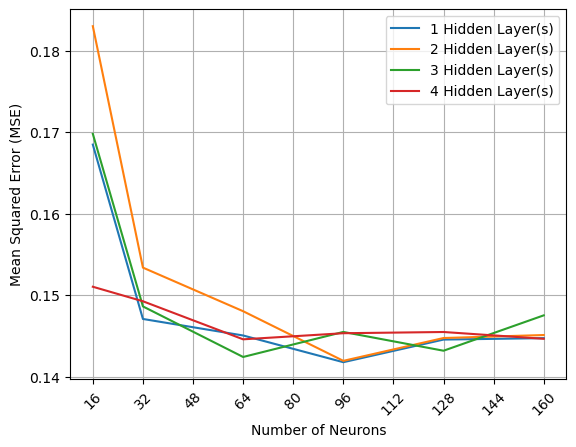

In [189]:
import matplotlib.pyplot as plt

# Filter DataFrame for each hidden layer and plot
hidden_layers = df_results['Hidden Layers'].unique()
for layer in hidden_layers:
    df_layer = df_results[df_results['Hidden Layers'] == layer]
    plt.plot(df_layer['Neurons'], df_layer['MSE'], label=f'{layer} Hidden Layer(s)')

# Set plot labels and title
plt.xlabel('Number of Neurons')
plt.ylabel('Mean Squared Error (MSE)')
# plt.title('MSE vs Neurons for Each Hidden Layer')
plt.legend()
plt.grid(True)
plt.xticks(range(int(df_results['Neurons'].min()), int(df_results['Neurons'].max())+1, 16), rotation=45)

# Show plot
plt.show()

In [ ]:
batch_size_results = []

In [111]:
hidden_layers = 1
neurons = 96
epochs = 150
batch_size = [10, 16, 32, 64]

for b in batch_size:
    print(f"Batch size: {b}"), 
    regressor, mse = initModel(hidden_layers, neurons, epochs, b)
    batch_size_results.append({'MSE': mse, 'Hidden Layers': hidden_layers, 'Neurons': neurons, 'Batch Size' : b, 'Model': regressor})

Batch size: 10
Epoch 1/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.7766 - val_loss: 0.4771
Epoch 2/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.4414 - val_loss: 0.4771
Epoch 3/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.4623 - val_loss: 0.4571
Epoch 4/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.4461 - val_loss: 0.3799
Epoch 5/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.4279 - val_loss: 0.3823
Epoch 6/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.3093 - val_loss: 0.2676
Epoch 7/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.2693 - val_loss: 0.2667
Epoch 8/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.2679 - val_loss: 0.2536
Epoch 9/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.2523 - val_loss: 0.2538
Epoch 10/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.2431 - val_loss: 0.2394
Epoch 11/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.2396 -

In [112]:
df_batch_size_results = pd.DataFrame(batch_size_results)

df_batch_size_results.sort_values(by='MSE').head(None)

,MSE,Hidden Layers,Neurons,Batch Size,Model
3,0.140007,1,80,64,"<Sequential name=sequential_31, built=True>"
14,0.140166,1,96,10,"<Sequential name=sequential_55, built=True>"
0,0.142031,1,80,10,"<Sequential name=sequential_28, built=True>"
12,0.142381,1,80,32,"<Sequential name=sequential_53, built=True>"
5,0.142513,2,80,10,"<Sequential name=sequential_43, built=True>"
15,0.142859,1,96,16,"<Sequential name=sequential_56, built=True>"
16,0.143188,1,96,32,"<Sequential name=sequential_57, built=True>"
10,0.143350,1,80,10,"<Sequential name=sequential_51, built=True>"
1,0.144116,1,80,16,"<Sequential name=sequential_29, built=True>"
2,0.144212,1,80,32,"<Sequential name=sequential_30, built=True>"


In [113]:
hidden_layers = 2
neurons = 96
epochs = 150
batch_size = [10, 16, 32, 64, 80]

for b in batch_size:
    print(f"Batch size: {b}"), 
    regressor, mse = initModel(hidden_layers, neurons, epochs, b)
    batch_size_results.append({'MSE': mse, 'Hidden Layers': hidden_layers, 'Neurons': neurons, 'Batch Size' : b, 'Model': regressor})

Batch size: 10
Epoch 1/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 0.6064 - val_loss: 0.2538
Epoch 2/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.2506 - val_loss: 0.2317
Epoch 3/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.2458 - val_loss: 0.2366
Epoch 4/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.2386 - val_loss: 0.2258
Epoch 5/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.2292 - val_loss: 0.2155
Epoch 6/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.2265 - val_loss: 0.2400
Epoch 7/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.2159 - val_loss: 0.2221
Epoch 8/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.2145 - val_loss: 0.2160
Epoch 9/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.2165 - val_loss: 0.2044
Epoch 10/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.2067 - val_loss: 0.1963
Epoch 11/150
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.2045 -

In [144]:
hidden_layers = 1
neurons = 96
epochs = 150
batch_size = [80]

for b in batch_size:
    print(f"Batch size: {b}"), 
    regressor, mse = initModel(hidden_layers, neurons, epochs, b)
    batch_size_results.append({'MSE': mse, 'Hidden Layers': hidden_layers, 'Neurons': neurons, 'Batch Size' : b, 'Model': regressor})

Batch size: 80
Epoch 1/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 1.6689 - val_loss: 0.5404
Epoch 2/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.5501 - val_loss: 0.5205
Epoch 3/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.5020 - val_loss: 0.5185
Epoch 4/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.4840 - val_loss: 0.4385
Epoch 5/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.3929 - val_loss: 0.3588
Epoch 6/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.3293 - val_loss: 0.3584
Epoch 7/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.2945 - val_loss: 0.2676
Epoch 8/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.2544 - val_loss: 0.2623
Epoch 9/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.2468 - val_loss: 0.2429
Epoch 10/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.2325 - val_loss: 0.2352
Epoch 11/150
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.2293 - val_loss: 0.2934
Epoch 12/150
1

In [151]:
df_batch_size_results = pd.DataFrame(batch_size_results)

df_batch_size_results.sort_values(by='MSE').head(None)

,MSE,Hidden Layers,Neurons,Batch Size,Model
3,0.140007,1,80,64,"<Sequential name=sequential_31, built=True>"
14,0.140166,1,96,10,"<Sequential name=sequential_55, built=True>"
0,0.142031,1,80,10,"<Sequential name=sequential_28, built=True>"
12,0.142381,1,80,32,"<Sequential name=sequential_53, built=True>"
5,0.142513,2,80,10,"<Sequential name=sequential_43, built=True>"
15,0.142859,1,96,16,"<Sequential name=sequential_56, built=True>"
19,0.142868,2,96,16,"<Sequential name=sequential_60, built=True>"
18,0.142949,2,96,10,"<Sequential name=sequential_59, built=True>"
16,0.143188,1,96,32,"<Sequential name=sequential_57, built=True>"
10,0.143350,1,80,10,"<Sequential name=sequential_51, built=True>"


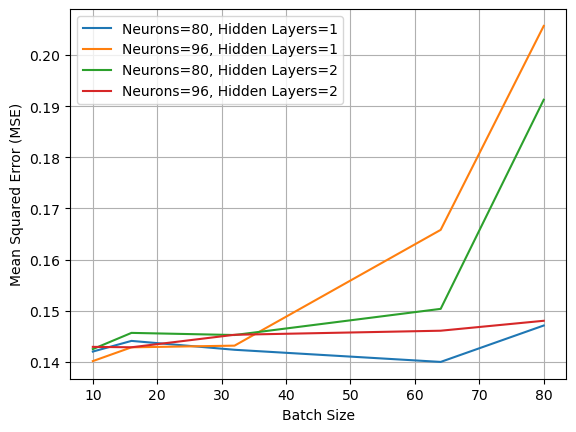

In [193]:
import matplotlib.pyplot as plt

df_sorted = df_batch_size_results.sort_values(by=['Hidden Layers', 'Neurons', 'Batch Size'])

# Define the combinations of Neurons and Hidden Layers
combinations = [
    {'Neurons': 80, 'Hidden Layers': 1},
    {'Neurons': 96, 'Hidden Layers': 1},
    {'Neurons': 80, 'Hidden Layers': 2},
    {'Neurons': 96, 'Hidden Layers': 2}
]

# Plot each combination separately
for combination in combinations:
    neurons_value = combination['Neurons']
    hidden_layers_value = combination['Hidden Layers']
    
    # Filter DataFrame for the current combination
    df_filtered = df_sorted[(df_sorted['Neurons'] == neurons_value) & (df_sorted['Hidden Layers'] == hidden_layers_value)]
    
    # Plot the filtered data
    plt.plot(df_filtered['Batch Size'], df_filtered['MSE'], label=f'Neurons={neurons_value}, Hidden Layers={hidden_layers_value}')

# Set plot labels and title
plt.xlabel('Batch Size')
plt.ylabel('Mean Squared Error (MSE)')
# plt.title('Batch Size vs MSE for Different Combinations of Neurons and Hidden Layers')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [116]:
for row in batch_size_results:
    row['Model'].save(str(row['Neurons']) + '_neurons_' + str(row['Hidden Layers']) + '_layers_' + str(row['Batch Size']) + '_Batch Size_' + '.keras')

In [185]:
best_model = min(batch_size_results, key=lambda x: x['MSE'])['Model']
best_model.summary()


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 80)             │        27,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,845 (319.71 KB)

 Trainable params: 27,281 (106.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54,564 (213.14 KB)

In [209]:
best_model.count_params()

27281

In [208]:
worst_model = max(results, key=lambda x: x['MSE'])['Model']
worst_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 82, 16)         │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,421 (40.71 KB)

 Trainable params: 3,473 (13.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,948 (27.14 KB)

In [201]:
X_test[0].shape

(82, 4)